<table>
 <tr align=left><td><img align=left src="https://i.creativecommons.org/l/by/4.0/88x31.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license.  
(c) Nicole Beisiegel</td>
</table>

In [1]:
%matplotlib inline
import h5py
import os
from HOS_Visualization import *
import types
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from subprocess import call

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# A High-Order Spectral Model for 3D Water Wave Simulations
## The _Testsuite_

This ipython notebook compiles and runs *WAVES* with various initial conditions and provides postprocessing routines to evaluate the results. The different test cases show the current capabilities of the model and include  

- [TEST 1: Commonly used ocean spectra and their physical behavior](## TEST 1: Commonly used ocean spectra and their physical behavior)
- [TEST 2: Wellbalancing: Periodic bathymetry and the still water state](## TEST 2: Wellbalancing: Periodic bathymetry and the still water state)
- [TEST 3: Periodic bathymetry and incoming wave (with relaxation zones)](## TEST 3: Periodic bathymetry and incoming wave (with relaxation zones))
- [TEST 4: Non-periodic bathymetry and incoming wave](## TEST 4: Non-periodic bathymetry and incoming wave )
- [TEST 5: Rogue waves](## TEST 5: Rogue waves)

A documentation and further information can be found for each test case below.

## TEST 1: Commonly used ocean spectra and their physical behavior

This part of the test suite shows that commonly used ocean spectra such as:

- the JONSWAP spectrum
- a Stokes wave train

can be correctly generated and simulated in a double periodic domain. Available `statistical` routines are used to evaluate the overall behavior of the simulations. 

## TEST 1.1: JONSWAP Spectrum

The `Jonswap` spectrum is defined as 

$$\begin{aligned}
    S(\omega) = \frac{\alpha g^2}{\omega^5} \exp\left( - \frac 5 4 \left(\frac{\omega_p}{\omega} \right)^4 \right)\gamma^r \qquad \mbox{ with } 
    r = \exp \left(- \frac{(\omega- \omega_p)^2}{2\sigma^2 \omega_p^2}\right)
\end{aligned}$$

and was first introduced in (Hasselmann et al., 1973).
Here, $\alpha$ is a slope factor, $g$ the gravitational acceleration, $\omega$ the frequency, $\omega_p$ the peak frequency, $\gamma$ the peak enhancement factor, and $\sigma$ a relative measure for the width of the peak.
Roughly speaking, it is the `Pierson Moskowitz` spectrum multiplied by an extra term $\gamma^r$.

---

Initial conditions for this test case can be found in `~/hos/data/initpars_jonswap_*.h5` and `~/hos/data/initdata_jonswap_*.h5` where `*` stands for the number of Fourier modes $N_x = Ny \in \{ 256, 512, 1024, 2048, 4096 \}$ with the following JONSWAP parameters

$$\begin{aligned}
\gamma &= 6\\
\theta &= 12^°\\
H_s &= 0.08 \\
\end{aligned}$$

We assume the mean water height to be $h=1000$ in a domain $\Omega=[0,12185.57]^2$ and $g=9.81$ run the simulation until $t=150s$ and save data every $1.0s$.

---

We investigate the dependence of resolution and maximum kurtosis as well as the evolution of the wave spectrum.
As stated in (Xiao et al., 2013) we expect the kurtosis to converge and, over time, the wave spectrum (for an initial narrow band spectrum) to expand.

In [10]:
# Compiles the code with the initial data for the JONSWAP test case
DIR = "/home/nicole/Development/hos/Csource/2dpar"
os.chdir(DIR)

call("make all",shell=True)
 
if not os.path.exists(DIR+"/JONSWAP"):
    %mkdir JONSWAP
        
resolution = [64,128,256,512]

for x in resolution:
    #print("Running code for resolution Nx = Ny = %s" str(x))
    call("rm initpars.h5", shell=True)
    call("ln -s ../../data/initpars_jonswap_"+str(x)+".h5 initpars.h5",shell=True)
        
    call("rm initdata.1.h5", shell=True)
    call("ln -s ../../data/initdata_jonswap_"+str(x)+".h5 initdata.1.h5",shell=True)
        
    dirname = "JONSWAP/JONSWAP_"+str(x)
    if not os.path.exists(DIR+"/"+str(dirname)):
        %mkdir $dirname
    
    call("mpirun -np 4 euler_2d_par initpars.h5", shell=True)
    %mv data* HOS_data* $dirname


64
128
256
512


KeyboardInterrupt: 

In [ ]:
MAINDIR = "/home/nicole/Development/hos/Csource/2dpar/JONSWAP"

SUBDIRS = [subdir[0] for subdir in os.walk(MAINDIR)]

kurtmax = []
Nxvec   = []

for DIR in SUBDIRS[1:]:
   
    iBound = 5
    idx    = []
    files  = []
    
    for file in os.listdir(DIR):
            if (file.startswith('data') & (file[4:7] != '_ex') & (file[4:7] != '_co')):
                idx.append(int(float(file[4:7])))
                files.append(file) 

    files = [x for (y,x) in sorted(zip(idx,files))]
    N = len(files)
    
    # Initialize vectors
    kurt  = [] 
    skew  = [] 
    t     = [] 
        
    
    for i, fileName in enumerate(files):
        f = h5py.File(DIR+"/"+fileName, "r")
        
        # read in all the data
        dataset = f.keys()[:]
        
        time = f[dataset[dataset.index(u'time')]][0] 
        eta  = f[dataset[dataset.index(u'eta')]][:,:] 
        phi  = f[dataset[dataset.index(u'phi')]][:,:] 
        Lx   = f[dataset[dataset.index(u'Lx')]][0] 
        Ly   = f[dataset[dataset.index(u'Ly')]][0] 
        Nx   = int(f[dataset[dataset.index(u'Nx')]][0][0])
        Ny   = int(f[dataset[dataset.index(u'Ny')]][0][0])
        g    = f[dataset[dataset.index(u'g')]][0]  
   
        Kx = np.asarray([2 * np.pi / Lx * x for x in np.arange(-Nx / 2,Nx / 2)])
        Ky = np.asarray([2 * np.pi / Ly * y for y in np.arange(-Ny / 2,Ny / 2)])
        x  = np.asarray([Lx / Nx * a for a in np.arange(0,Nx)])
        y  = np.asarray([Ly / Ny * b for b in np.arange(0,Ny)])

        eta_vec = eta.reshape((1,Nx * Ny))

        t.append(i) 

        mu3     = np.mean(np.power(np.asarray([ ev - np.mean(eta_vec) for ev in eta_vec]),3))
        mu4     = np.mean(np.power(np.asarray([ ev - np.mean(eta_vec) for ev in eta_vec]),4))
        
        # compute kurtosis and skewness of the sea surface displacement eta.
        skew.append(mu3/np.power(np.std(eta_vec),3))
        kurt.append(mu4/np.power(np.std(eta_vec),4))

    kurtmax.append(np.amax(kurt))
    Nxvec.append(Nx)        
    tvec = np.asarray([elmt * 60. for elmt in t])
    print DIR
    PlotSpectraEvolution(DIR, "/data0.1.h5", "/data150.1.h5")
    
    
plt.figure()
plt.title("JONSWAP: Maximal kurtosis", fontsize=18)
plt.plot(Nxvec,kurtmax,'*')
plt.xlabel("Resolution [Nx]", fontsize=18)
plt.ylabel("Max. kurtosis [$\mu_4$ / $\sigma^4$]", fontsize=18)
plt.show()

plt.close()

## TEST 1.3: Stokes Wave
We use a second order approximation of a Stokes wave train in a rectangular basin $\Omega = [0,2\pi]^2$ (see Craig & Sulem, 1993)

$$\begin{aligned}
\eta(\textbf x, t=0) &= a \cos (k x) + \mu_2 a^2 \cos(2kx) \\
\phi(\textbf x, z=\eta, t=0) &= \nu_1 a \cosh(k(\eta + h)) \sin(kx) + \nu_2 a^2 \cosh(2k(\eta + h)) \sin(2kx)
\end{aligned}$$

with 

$\begin{aligned}
\mu_2 &= \frac 1 2 k \coth(hk) \left( 1 + \frac{3}{2 \sinh^2(kh)}\right)\\
\nu_1 &= \frac{\omega}{k \sinh(hk)}\\
\nu_2 &= \frac 3 8 \frac{\omega}{k \sinh^4(hk)},
\end{aligned}$

where $\omega$ is determined using the dispersion relation $\omega^2 = gk \tanh(hk)$.  
The parameters are chosen as $k=5, a=0.065, t=1$ and we run the simulation until $t=12s$ with a timestep of $\Delta t = 0.05s$ and with $N_x = N_y = 2^{8}$ Fourier nodes. 
The simulation data is saved every $0.1s$.

The intial data is saved as `~/hos/data/initdata_stokes.h5` and `~/hos/data/initpars_stokes.h5`.

Running the simulation for that amount of time takes approximately 500s.  
It should be observed that the wave train travels exactly one time through the whole domain within $12s$.

To compare with Fig. 2a of Craig & Sulem, 1993 a (x,t) plot follows. 

In [2]:
# Compiles the code with the initial data for the Stokes wave train
DIR = "/home/nicole/Development/hos/Csource/2dpar"
os.chdir(DIR)

call("make all",shell=True)

call("rm initpars.h5", shell=True)
call("ln -s ../../data/initpars_stokes.h5 initpars.h5", shell=True)
call("rm initdata.1.h5", shell=True)
call("ln -s ../../data/initdata_stokes.h5 initdata.1.h5", shell=True)

dirname = "StokesWaveTrain"
if not os.path.exists(DIR+"/"+str(dirname)):
    %mkdir $dirname
    
call("./euler_2d_par initpars.h5", shell=True)
%mv data* HOS_data* $dirname


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


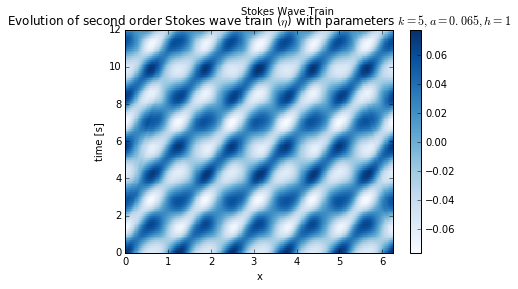

In [3]:
#-- This script produces a (x,t) plot of the wave elevation $\eta$

# Path to the directory where the data*.h5 files are saved
DATDIR =  "/home/nicole/Development/hos/Csource/2dpar/StokesWaveTrain/" 

# Initialize arrays
idx   = []
files = []
j     = 0

for file in os.listdir(DATDIR):
    if (file.startswith('data') & (file[4:7] != '_ex')& (file[4:7] != '_co')):
        idx.append(int(float(file[4:7])))
        files.append(file) #(file[4:12])

files = [x for (y,x) in sorted(zip(idx,files))]


for fileName in files:
    f = h5py.File(DATDIR+fileName, "r")
        
    # Get time, x coordinates and eta from files
    dataset  = f.keys()[:]    
    
    if (j == 0):
        N = len(files)
        time  = np.zeros(N)
        Lx   = f[dataset[dataset.index(u'Lx')]][0]
        Nx   = f[dataset[dataset.index(u'Nx')]][0]
        x    = np.asarray([(Lx / Nx) * x for x in np.arange(0,Nx,1)])
        eta  = np.zeros((Nx,N))
    
    time[j]  = f[dataset[dataset.index(u'time')]][0]
    eta[:,j] = f[dataset[dataset.index(u'eta')]][0][:]

    j += 1


# Plot the data
fig = plt.figure(1)
fig.set_figwidth(fig.get_figwidth() * 1)
fig.set_figheight(fig.get_figheight() * 1)

plt.suptitle("Stokes Wave Train") #,fontsize=18)

plt.subplot(111)
plt.pcolor(x.T,time,eta.T,cmap=plt.get_cmap("Blues"))
plt.colorbar()
plt.title("Evolution of second order Stokes wave train ($\eta$) with parameters $k=5, a=0.065, h=1$")#,fontsize=18)
plt.xlabel("x") #,fontsize=18)
plt.ylabel("time [s]") #,fontsize=18)
plt.xlim(np.amin(x), np.amax(x))
plt.ylim(np.amin(time), np.amax(time))

# JIC you like a single shapshot at time t
# plt.figure(2)
# plt.plot(x,eta[:,12])
# plt.xlim(np.amin(x),np.amax(x))
# plt.title("Snapshot: Surface elevation at time t")

plt.show()
plt.close()

The plot from Craig & Sulem for comparison:


![Plot from Craig & Sulem](craig_sulem_plot "The plot from Craig & Sulem for comparison")

## TEST 1.3 (to come): Gauss Spectrum

The Gauss spectrum is probably the easiest random wave spectrum you could think of.  
It is defined as

$$
    \Psi(k_x, k_y) = \frac{\sigma^2}{2\pi \delta_k^2} \exp \left(- \frac 1 {2k_p^2} \left( \frac{(k_x - k_p)^2}{\delta_k^2} + \frac{k_y^2}{\delta_k^2}\right)\right)
$$

and will be added to the testcase soon.

## TEST 2: Wellbalancing: Periodic bathymetry and the still water state

In a domain $\Omega = [0,25]\times[0,30]$ we prescribe the bathymetry $b = b(x,y)$ as an elliptical (and periodic) hill around $(x_0,y_0)^{\top} = (6.1,13.72)^{\top}$ defined within a unit circle given by

$$\begin{aligned}
    \left(\frac{x-x_0}{3.05}\right)^2 + \left( \frac{y-y_0}{3.96}\right)^2 \leq 1
\end{aligned}$$

as

$$\begin{aligned}
    b(x,y) = -0.4572 + 0.7620 \cdot \sqrt{1. - \left(\frac{x-x_0}{3.81}\right)^2 - \left(\frac{y- y_0}{4.95}\right)^2 }
\end{aligned}$$

The parameters are chosen as in (Vincent & Briggs, 1989).   
The initial free surface is chosen to be constant and of depth $h=45.72$ where there is no bathymetry and the potential is zero everywhere.

The intial data is saved as `~/hos/data/initdata_wellbalancing.h5` and `~/hos/data/initpars_wellbalancing.h5`.

We run the simulation with a time step of $\Delta t = 0.2$ until a final time $T_{end} = 50s$.
Running the simulation for that amount of time takes approximately ??s.

So far, there is no literature on wellbalancing of high-order spectral models. This test case is meant to transfer the concept of wellbalancing that has originated from finite volume and finite element type methods to HOS.

We plot the maximum velocity over time.

In [4]:
# Compiles the code with the initial data for the Wellbalancing test case
DIR = "/home/nicole/Development/hos/Csource/2dpar"
os.chdir(DIR)

call("make all",shell=True)

call("rm initpars.h5", shell=True)
call("ln -s ../../data/initpars_wellbalancing.h5 initpars.h5", shell=True)
call("rm initdata.1.h5", shell=True)
call("ln -s ../../data/initdata_wellbalancing.h5 initdata.1.h5", shell=True)

dirname = "Wellbalancing"
if not os.path.exists(DIR+"/"+str(dirname)):
    %mkdir $dirname
    
call("mpirun -np 4 euler_2d_par initpars.h5", shell=True)
%mv data* HOS_data* $dirname


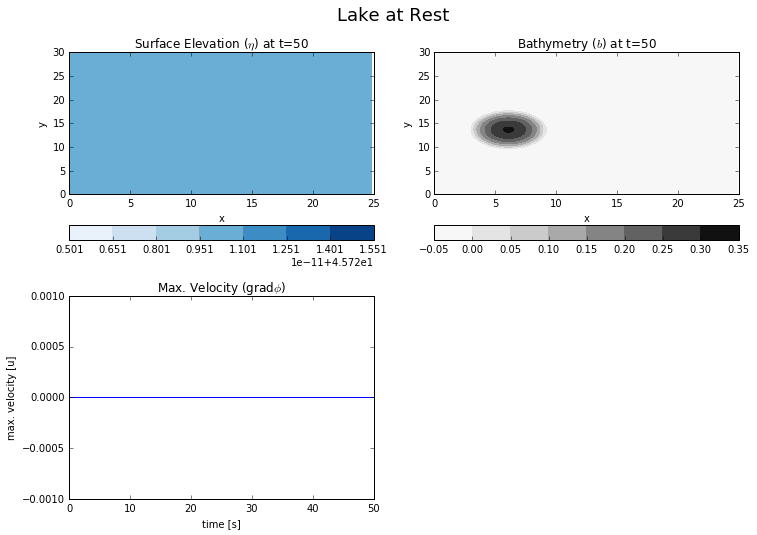

In [5]:
#def divergence(field):
#    "return the divergence of a n-D field"
#    return np.sum(np.gradient(field),axis=0)

# Plot bathymetry and eta for final time step and divergence of phi over time.    
fig = plt.figure()
plt.suptitle("Lake at Rest",fontsize=18)
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)


DIR = "/home/nicole/Development/hos/Csource/2dpar/Wellbalancing/" 
finalfileName = "data50.1.h5"

f = h5py.File(DIR+finalfileName, "r")
dataset = f.keys()[:]

Nx   = f[dataset[dataset.index(u'Nx')]][0]
Ny   = f[dataset[dataset.index(u'Ny')]][0]
    
Lx   = f[dataset[dataset.index(u'Lx')]][0]
Ly   = f[dataset[dataset.index(u'Ly')]][0]
    
x = np.asarray([(Lx / Nx) * x for x in np.arange(0,Nx,1)])
y = np.asarray([(Ly / Ny) * y for y in np.arange(0,Ny,1)])

X,Y = np.meshgrid(x,y)

plt.subplot(221) 
plt.contourf(X,Y,f[dataset[dataset.index(u'eta')]][:,:], cmap = plt.get_cmap("Blues"))
plt.colorbar(orientation = 'horizontal')
plt.title("Surface Elevation ($\eta$) at t=50") 
plt.xlabel("x") 
plt.ylabel("y") 
plt.xlim(0.0, Lx)
plt.ylim(0.0, Ly)

plt.subplot(222)
plt.contourf(X,Y,f[dataset[dataset.index(u'bat')]][:,:], cmap = plt.get_cmap("Greys"))
plt.colorbar(orientation = 'horizontal')
plt.title("Bathymetry ($b$) at t=50") 
plt.xlabel("x") 
plt.ylabel("y") 
plt.xlim(0.0, Lx)
plt.ylim(0.0, Ly)

# Initialize quantities
idx   = []
files = []
time  = []
velo  = []

# Pick and sort all data files
for file in os.listdir(DIR):
    if (file.startswith('data') & (file[4:7] != '_ex')& (file[4:7] != '_co')):
        idx.append(int(float(file[4:7])))
        files.append(file) 

files = [x for (y,x) in sorted(zip(idx,files))]

for fileName in files:
    f = h5py.File(DIR+fileName, "r")
    
    dataset = f.keys()[:]    
    phi     = f[dataset[dataset.index(u'phi')]][:,:]
        
    time.append(f[dataset[dataset.index(u'time')]][0])
    velo.append(np.amax(np.abs(np.gradient(phi))))
    
    f.close()

plt.subplot(223) 
plt.plot(time, velo)
plt.title("Max. Velocity (grad$\phi$)")
plt.xlabel("time [s]")
plt.ylabel("max. velocity [u]")
plt.xlim(0.0, np.amax(time))
plt.ylim(-0.001,0.001) 


plt.show()
plt.close()

## TEST 3: Periodic bathymetry and Stokes waves (without relaxation zones)

In [6]:
# Compiles the code with the initial data for the Wellbalancing test case
DIR = "/home/nicole/Development/hos/Csource/2dpar"
os.chdir(DIR)

call("make all",shell=True)

call("rm initpars.h5", shell=True)
call("ln -s ../../data/initpars_stokeshill.h5 initpars.h5", shell=True)
call("rm initdata.1.h5", shell=True)
call("ln -s ../../data/initdata_stokeshill.h5 initdata.1.h5", shell=True)

dirname = "StokesHill"
if not os.path.exists(DIR+"/"+str(dirname)):
    %mkdir $dirname
    
call("mpirun -np 4 euler_2d_par initpars.h5", shell=True)
%mv data* HOS_data* $dirname


## TEST 3: Periodic bathymetry and incoming wave (with relaxation zones)

## TEST 4: Non-periodic bathymetry and incoming wave 

## Rienecker & Fenton

## TEST 5: Rogue waves